In [ ]:
!git clone https://github.com/dome272/wuerstchen/
%cd wuerstchen
!pip install transformers git+https://github.com/pabloppp/pytorch-tools

fatal: destination path 'wuerstchen' already exists and is not an empty directory.
/content/wuerstchen
  Cloning https://github.com/pabloppp/pytorch-tools to /tmp/pip-req-build-88t_jaxy
  Running command git clone --filter=blob:none --quiet https://github.com/pabloppp/pytorch-tools /tmp/pip-req-build-88t_jaxy
  Resolved https://github.com/pabloppp/pytorch-tools to commit 6472bd5e223142bfbe105e2006432252f1ce3709
  Preparing metadata (setup.py) ... done


In [ ]:
%cd wuerstchen
import os
import time
import torch
import torchvision
from PIL import Image
from vqgan import VQModel
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, T5EncoderModel, CLIPTextModel
from torch.utils.data import DataLoader
from modules import Paella, EfficientNetEncoder, Prior, DiffNeXt, sample
from diffuzz import Diffuzz
import transformers
transformers.utils.logging.set_verbosity_error()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def showimages(imgs, rows=False, **kwargs):
    plt.figure(figsize=(kwargs.get("width", 32), kwargs.get("height", 32)))
    plt.axis("off")
    if rows:
        plt.imshow(torch.cat([torch.cat([i for i in row], dim=-1) for row in imgs], dim=-2).permute(1, 2, 0).cpu())
    else:
        plt.imshow(torch.cat([torch.cat([i for i in imgs], dim=-1)], dim=-2).permute(1, 2, 0).cpu())
    plt.show()
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

[Errno 2] No such file or directory: 'wuerstchen'
/content/wuerstchen
Using device: cuda:0


In [ ]:
!wget https://huggingface.co/dome272/wuerstchen/resolve/main/model_stage_b.pt
!wget https://huggingface.co/dome272/wuerstchen/resolve/main/model_stage_c_ema.pt
!wget https://huggingface.co/dome272/wuerstchen/resolve/main/vqgan_f4_v1_500k.pt

!mkdir models
!mv vqgan_f4_v1_500k.pt models
!mv model_* models

--2024-05-11 00:52:15--  https://huggingface.co/dome272/wuerstchen/resolve/main/model_stage_b.pt
Resolving huggingface.co (huggingface.co)... 108.157.254.24, 108.157.254.78, 108.157.254.64, ...
Connecting to huggingface.co (huggingface.co)|108.157.254.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/b9/6e/b96ebc9f17a640b8e89f419a072a1ef4e6dadbcdf69a668bf2518fc87cd52c63/6cfd09dbe8765a7f973dc96f7b1f2e8328e35bab414f556d67d994676c19c6d5?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27model_stage_b.pt%3B+filename%3D%22model_stage_b.pt%22%3B&Expires=1715647935&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNTY0NzkzNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9iOS82ZS9iOTZlYmM5ZjE3YTY0MGI4ZTg5ZjQxOWEwNzJhMWVmNGU2ZGFkYmNkZjY5YTY2OGJmMjUxOGZjODdjZDUyYzYzLzZjZmQwOWRiZTg3NjVhN2Y5NzNkYzk2ZjdiMWYyZTgzMjhlMzViYWI0MTRmNTU2ZDY3ZDk5NDY3NmMxOWM2ZDU%

In [ ]:
checkpoint_stage_a = "models/vqgan_f4_v1_500k.pt"
checkpoint_stage_b = "models/model_stage_b.pt"

effnet_preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(384, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, antialias=True),
    torchvision.transforms.CenterCrop(384),
    torchvision.transforms.Normalize(
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    )
])

def decode(img_seq):
    return vqmodel.decode_indices(img_seq)

def embed_clip(caption, negative_caption="", batch_size=4, device="cuda"):
    clip_tokens = clip_tokenizer([caption] * batch_size, truncation=True, padding="max_length", max_length=clip_tokenizer.model_max_length, return_tensors="pt").to(device)
    clip_text_embeddings = clip_model(**clip_tokens).last_hidden_state

    clip_tokens_uncond = clip_tokenizer([negative_caption] * batch_size, truncation=True, padding="max_length", max_length=clip_tokenizer.model_max_length, return_tensors="pt").to(device)
    clip_text_embeddings_uncond = clip_model(**clip_tokens_uncond).last_hidden_state
    return clip_text_embeddings, clip_text_embeddings_uncond

vqmodel = VQModel().to(device)
vqmodel.load_state_dict(torch.load(checkpoint_stage_a, map_location=device)["state_dict"])
vqmodel.eval().requires_grad_(False)

clip_model = CLIPTextModel.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K").to(device).eval().requires_grad_(False)
clip_tokenizer = AutoTokenizer.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")

diffuzz = Diffuzz(device=device)

pretrained_checkpoint = torch.load(checkpoint_stage_b, map_location=device)

effnet = EfficientNetEncoder(effnet="efficientnet_v2_l").to(device)
effnet.load_state_dict(pretrained_checkpoint['effnet_state_dict'])
effnet.eval().requires_grad_(False)

# - Paella Model as generator -
generator = Paella(byt5_embd=1024).to(device)
generator.load_state_dict(pretrained_checkpoint['state_dict'])
generator.eval().requires_grad_(False)

del pretrained_checkpoint



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Using EffNet L.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
checkpoint_stage_c = "../drive/MyDrive/Applied_CV/Final_Project/2252_iters_prior.pth"

checkpoint = torch.load(checkpoint_stage_c, map_location=device)
model = Prior(c_in=16, c=1536, c_cond=1024, c_r=64, depth=32, nhead=24).to(device)
model.load_state_dict(checkpoint['ema_state_dict'])
model.eval().requires_grad_(False)
del checkpoint

torch.cuda.empty_cache()

Prior Sampling: 3.51763653755188


Generator Sampling: 2.4194529056549072
Decoder Generation: 0.008315801620483398
Temperature: (1.0, 0.6), CFG: (2.0, 2.0), Steps: 8
cartoon style: 3 dogs in front of a castle on a hill


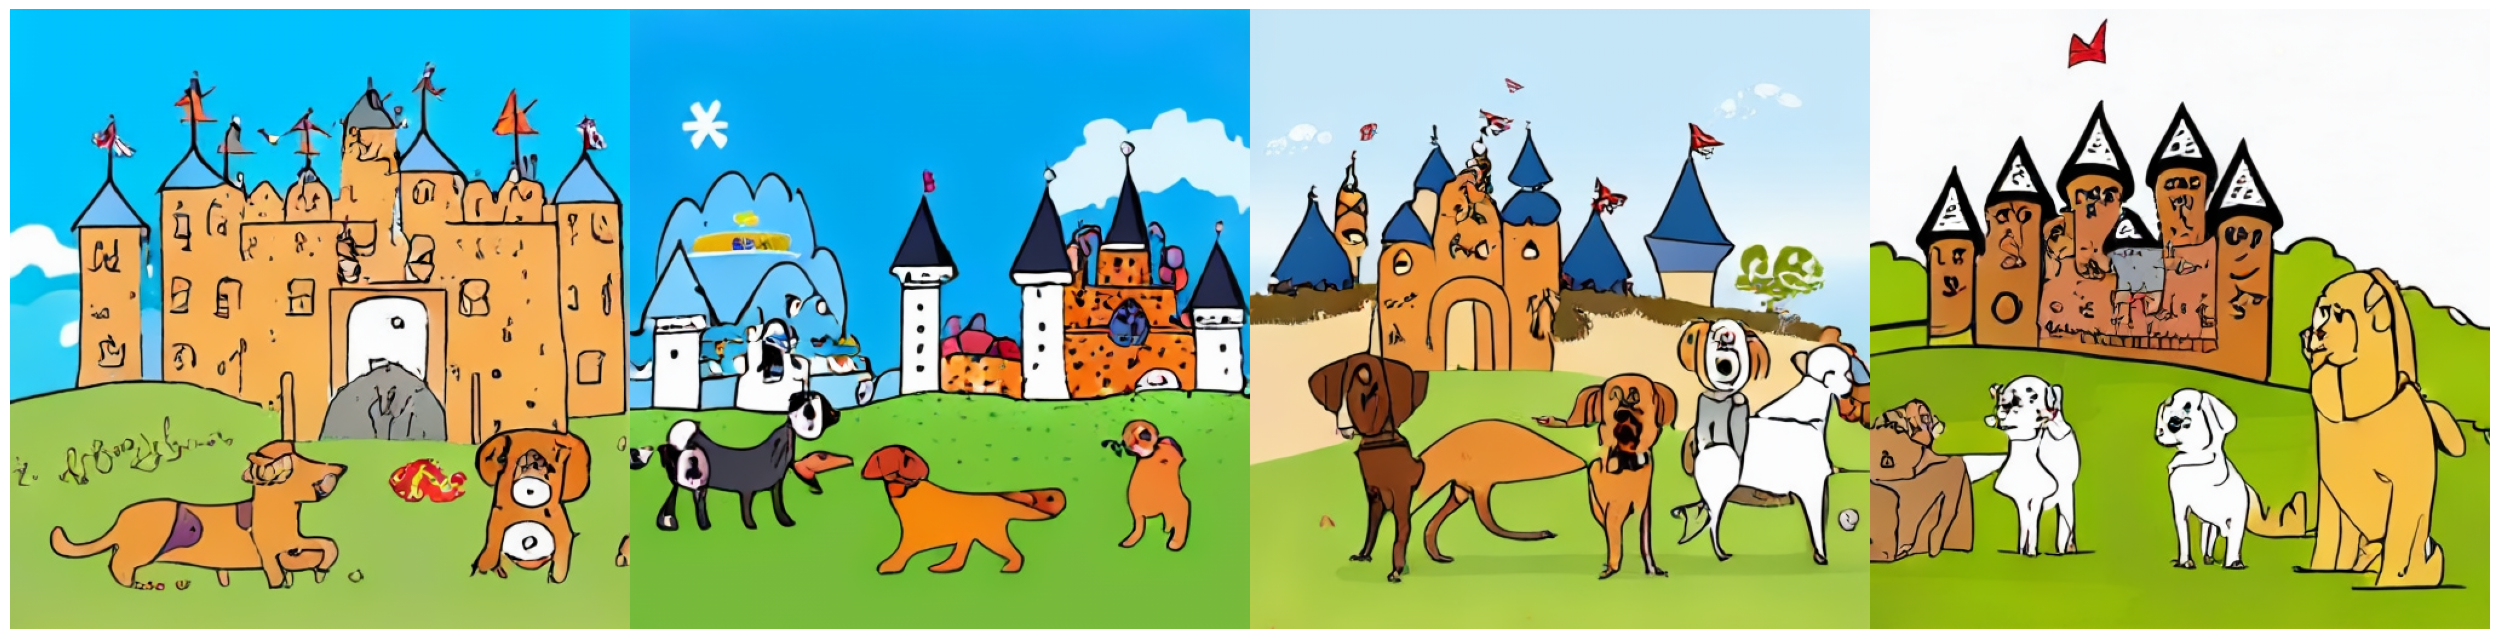

In [ ]:
batch_size = 4
caption = "cartoon style: 3 dogs in front of a castle on a hill"
negative_caption = "low resolution, low detail, bad quality, blurry"
# negative_caption = ""
prior_timesteps = 60
prior_cfg = 6
prior_sampler = "ddpm"

clip_text_embeddings, clip_text_embeddings_uncond = embed_clip(caption, negative_caption, batch_size, device)

effnet_features_shape = (batch_size, 16, 12, 12)
effnet_embeddings_uncond = torch.zeros(effnet_features_shape).to(device)
generator_latent_shape = (batch_size, 128, 128)
# torch.manual_seed(42)
with torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.no_grad():
    s = time.time()
    sampled = diffuzz.sample(model, {'c': clip_text_embeddings}, unconditional_inputs={"c": clip_text_embeddings_uncond}, shape=effnet_features_shape,
                            timesteps=prior_timesteps, cfg=prior_cfg, sampler=prior_sampler,
                            t_start=1.0)[-1]
    print(f"Prior Sampling: {time.time() - s}")
    temperature, cfg, steps =(1.0, 0.6), (2.0, 2.0), 8
    s = time.time()
    sampled_images_original, intermediate = sample(
        generator, {'effnet': sampled,'byt5': clip_text_embeddings}, generator_latent_shape, unconditional_inputs = {'effnet': effnet_embeddings_uncond, 'byt5': clip_text_embeddings_uncond},
        temperature=temperature, cfg=cfg, steps=steps
    )
    print(f"Generator Sampling: {time.time() - s}")

s = time.time()
sampled = decode(sampled_images_original)
print(f"Decoder Generation: {time.time() - s}")
# intermediate = [decode(i) for i in intermediate]
print(f"Temperature: {temperature}, CFG: {cfg}, Steps: {steps}")
print(caption)
showimages(sampled)
# showimages(intermediate, rows=True)